In [1]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import DataFrame
from pandas import Grouper
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')
# from dataprep.eda import plot, plot_correlation, plot_missing, create_report
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV
import itertools
import warnings
warnings.filterwarnings('ignore')

In [2]:
# tỉ lệ 8:2
df = pd.read_csv('F:/hk2 nam3/nhi/is403/IS403_O21_04/Dataset/NVL Historical Data 1_6.csv')
df['Price'] = df['Price'].str.replace('$', '', regex=True)
df['Price'] = df['Price'].str.replace(',', '', regex=True)
df['Price'] = df.Price.astype(float)
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df[::-1]

df = df.reset_index(drop=True) # Reset the index

In [3]:
# Split the data into training, testing, and validation sets
train_size = int(0.8 * len(df))
train_data = df[:train_size]
test_data = df[train_size:]

In [4]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])

In [5]:
final_model = SimpleExpSmoothing(x_train).fit(optimized=True)
y_pred = final_model.forecast(320)

In [6]:
# 6. Quá trình tạo index predict 90 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+90, step=1)
last_data1 = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
last_data2 = pd.RangeIndex(start=last_index+31, stop=last_index+60, step=1)
last_data3 = pd.RangeIndex(start=last_index+61, stop=last_index+90, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_90_days = np.array(range(last_index+1, last_index+91)).reshape(-1, 1)

y_next_90_days = final_model.forecast(len(x_next_90_days))
y_next_90_days



array([1276.99999999, 1276.99999999, 1276.99999999, 1276.99999999,
       1276.99999999, 1276.99999999, 1276.99999999, 1276.99999999,
       1276.99999999, 1276.99999999, 1276.99999999, 1276.99999999,
       1276.99999999, 1276.99999999, 1276.99999999, 1276.99999999,
       1276.99999999, 1276.99999999, 1276.99999999, 1276.99999999,
       1276.99999999, 1276.99999999, 1276.99999999, 1276.99999999,
       1276.99999999, 1276.99999999, 1276.99999999, 1276.99999999,
       1276.99999999, 1276.99999999, 1276.99999999, 1276.99999999,
       1276.99999999, 1276.99999999, 1276.99999999, 1276.99999999,
       1276.99999999, 1276.99999999, 1276.99999999, 1276.99999999,
       1276.99999999, 1276.99999999, 1276.99999999, 1276.99999999,
       1276.99999999, 1276.99999999, 1276.99999999, 1276.99999999,
       1276.99999999, 1276.99999999, 1276.99999999, 1276.99999999,
       1276.99999999, 1276.99999999, 1276.99999999, 1276.99999999,
       1276.99999999, 1276.99999999, 1276.99999999, 1276.99999

In [7]:
test_mae = mean_absolute_error(test_data, y_pred)
test_mape = mean_absolute_percentage_error(test_data, y_pred)
test_rmse = sqrt(mean_squared_error(test_data, y_pred))

print('MAE:', test_mae)
print('RMSE:', test_rmse)
print('MAPE:', test_mape)


MAE: 14325.187500014901
RMSE: 14525.30738488611
MAPE: 0.9161275133330097


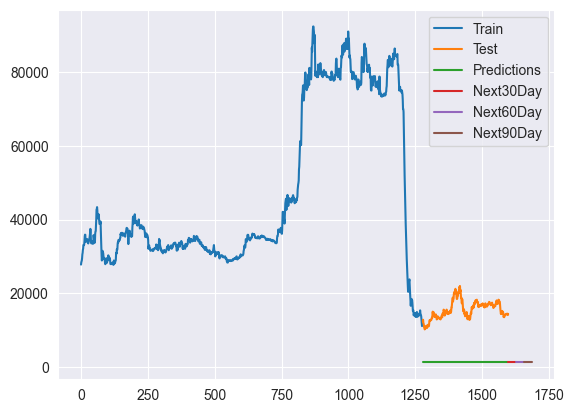

In [8]:
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(test_data.index, y_pred)
plt.plot(last_data1,y_next_90_days[0:30])
plt.plot(last_data2,y_next_90_days[31:60])
plt.plot(last_data3,y_next_90_days[61:90])
plt.legend(['Train', 'Test', 'Predictions','Next30Day', 'Next60Day', 'Next90Day'])
plt.show()

In [9]:
def plot_model(train, test, y_pred, title):
  mae = mean_absolute_error(test, y_pred)
  train.plot(figsize=(15, 4), legend=True, label="TRAIN", title=f"{title}, MAE: {round(mae, 2)}")
  test.plot(legend=True, label="TEST")
  y_pred.plot(legend=True, label="PREDICTION")
  plt.show()

def des_optimizer(train, test, alphas, betas, trend, step):
    best_alpha, best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend=trend).fit(smoothing_level=alpha, smoothing_slope=beta)
            y_pred = des_model.forecast(step)
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae
    return best_alpha, best_beta, best_mae


alphas = np.arange(0.01, 1, 0.10)
betas = np.arange(0.01, 1, 0.10)
best_alpha, best_beta, best_mae = des_optimizer(x_train, x_test, alphas, betas, trend='add', step=320)
final_model = ExponentialSmoothing(x_train, trend='add').fit(smoothing_level=best_alpha, smoothing_slope=best_beta)
y_pred = final_model.forecast(320)

In [10]:
# 6. Quá trình tạo index predict 90 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+90, step=1)
last_data1 = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
last_data2 = pd.RangeIndex(start=last_index+31, stop=last_index+60, step=1)
last_data3 = pd.RangeIndex(start=last_index+61, stop=last_index+90, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_90_days = np.array(range(last_index+1, last_index+91)).reshape(-1, 1)

y_next_90_days = final_model.forecast(len(x_next_90_days))
y_next_90_days



array([1278., 1279., 1280., 1281., 1282., 1283., 1284., 1285., 1286.,
       1287., 1288., 1289., 1290., 1291., 1292., 1293., 1294., 1295.,
       1296., 1297., 1298., 1299., 1300., 1301., 1302., 1303., 1304.,
       1305., 1306., 1307., 1308., 1309., 1310., 1311., 1312., 1313.,
       1314., 1315., 1316., 1317., 1318., 1319., 1320., 1321., 1322.,
       1323., 1324., 1325., 1326., 1327., 1328., 1329., 1330., 1331.,
       1332., 1333., 1334., 1335., 1336., 1337., 1338., 1339., 1340.,
       1341., 1342., 1343., 1344., 1345., 1346., 1347., 1348., 1349.,
       1350., 1351., 1352., 1353., 1354., 1355., 1356., 1357., 1358.,
       1359., 1360., 1361., 1362., 1363., 1364., 1365., 1366., 1367.])

In [11]:
test_mae = mean_absolute_error(test_data, y_pred)
test_mape = mean_absolute_percentage_error(test_data, y_pred)
test_rmse = sqrt(mean_squared_error(test_data, y_pred))

print('MAE:', test_mae)
print('RMSE:', test_rmse)
print('MAPE:', test_mape)


MAE: 14164.6875
RMSE: 14360.595145658135
MAPE: 0.9060876814015671


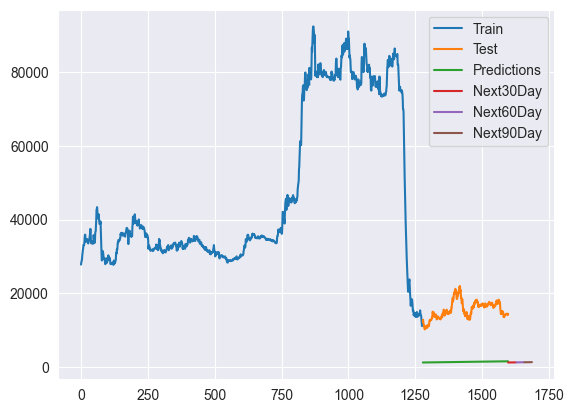

In [12]:
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(test_data.index, y_pred)
plt.plot(last_data1,y_next_90_days[0:30])
plt.plot(last_data2,y_next_90_days[31:60])
plt.plot(last_data3,y_next_90_days[61:90])
plt.legend(['Train', 'Test', 'Predictions','Next30Day', 'Next60Day', 'Next90Day'])
plt.show()

In [13]:
def tes_optimizer(train, test, abg, trend, seasonal, seasonal_periods, step):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods).\
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(step)
        if np.isnan(y_pred).any():
            continue  # Skip this combination if y_pred contains NaN values
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae

    return best_alpha, best_beta, best_gamma, best_mae

alphas = betas = gammas = np.arange(0.10, 1, 0.10)
abg = list(itertools.product(alphas, betas, gammas))
best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(x_train, x_test, abg=abg, trend='add', seasonal='add', seasonal_periods=12, step=320)
final_model = ExponentialSmoothing(y_train, trend='add', seasonal='add', seasonal_periods=12).fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)
y_pred = final_model.forecast(320)



In [14]:
# 6. Quá trình tạo index predict 90 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+90, step=1)
last_data1 = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
last_data2 = pd.RangeIndex(start=last_index+31, stop=last_index+60, step=1)
last_data3 = pd.RangeIndex(start=last_index+61, stop=last_index+90, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_90_days = np.array(range(last_index+1, last_index+91)).reshape(-1, 1)

y_next_90_days = final_model.forecast(len(x_next_90_days))
y_next_90_days



array([ 12274.57737085,  12460.03275442,  12105.05555013,  11043.87926159,
        10339.33639303,   9971.77499049,   9372.99060135,   8611.10447712,
         7901.1195836 ,   7284.17912061,   7382.77749097,   8018.67470227,
         7543.67709328,   7729.13247685,   7374.15527256,   6312.97898402,
         5608.43611546,   5240.87471292,   4642.09032378,   3880.20419955,
         3170.21930603,   2553.27884304,   2651.8772134 ,   3287.7744247 ,
         2812.77681571,   2998.23219929,   2643.25499499,   1582.07870645,
          877.5358379 ,    509.97443535,    -88.80995379,   -850.69607802,
        -1560.68097154,  -2177.62143452,  -2079.02306417,  -1443.12585287,
        -1918.12346185,  -1732.66807828,  -2087.64528258,  -3148.82157112,
        -3853.36443967,  -4220.92584222,  -4819.71023136,  -5581.59635558,
        -6291.5812491 ,  -6908.52171209,  -6809.92334174,  -6174.02613044,
        -6649.02373942,  -6463.56835585,  -6818.54556014,  -7879.72184869,
        -8584.26471724,  

In [15]:
test_mae = mean_absolute_error(test_data, y_pred)
test_mape = mean_absolute_percentage_error(test_data, y_pred)
test_rmse = sqrt(mean_squared_error(test_data, y_pred))

print('MAE:', test_mae)
print('RMSE:', test_rmse)
print('MAPE:', test_mape)


MAE: 66579.27075077026
RMSE: 76432.76492375576
MAPE: 4.150348546111081


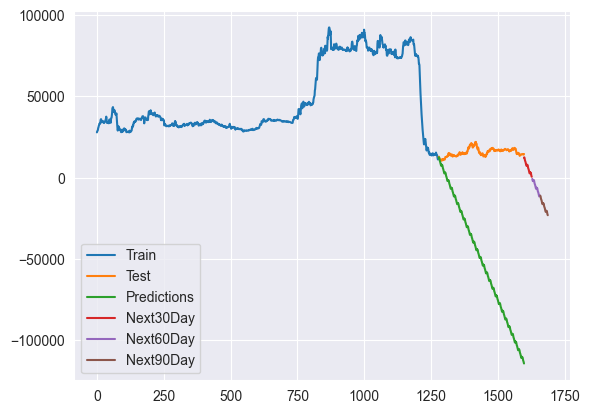

In [16]:
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(test_data.index, y_pred)
plt.plot(last_data1,y_next_90_days[0:30])
plt.plot(last_data2,y_next_90_days[31:60])
plt.plot(last_data3,y_next_90_days[61:90])
plt.legend(['Train', 'Test', 'Predictions','Next30Day', 'Next60Day', 'Next90Day'])
plt.show()

In [17]:
def tes_optimizer(train, test, abg, trend, seasonal, seasonal_periods, step):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        try:
            tes_model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods).\
                fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
            y_pred = tes_model.forecast(step)
            if np.isnan(y_pred).any():
                continue  # Skip this combination if y_pred contains NaN values
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
        except ValueError as e:
            if "strictly positive" in str(e):
                continue  # Skip this combination if the error is due to non-positive values
            else:
                raise e

    return best_alpha, best_beta, best_gamma, best_mae


alphas = betas = gammas = np.arange(0.10, 1, 0.10)
abg = list(itertools.product(alphas, betas, gammas))
best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(x_train, x_test, abg=abg, trend='mul', seasonal='mul', seasonal_periods=12, step=320)
final_model = ExponentialSmoothing(y_train, trend='mul', seasonal='mul', seasonal_periods=12).fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)
y_pred = final_model.forecast(320)


In [18]:
# 6. Quá trình tạo index predict 90 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+90, step=1)
last_data1 = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
last_data2 = pd.RangeIndex(start=last_index+31, stop=last_index+60, step=1)
last_data3 = pd.RangeIndex(start=last_index+61, stop=last_index+90, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_90_days = np.array(range(last_index+1, last_index+91)).reshape(-1, 1)

y_next_90_days = final_model.forecast(len(x_next_90_days))
y_next_90_days



array([11471.61159713, 11370.23127464, 11040.1119013 , 10780.68064893,
       10702.85734727, 10630.0927085 , 10486.59735451, 10349.70036298,
       10195.95810181, 10056.21145809, 10028.15610795,  9890.49373933,
        9759.80379536,  9673.5515676 ,  9392.6930077 ,  9171.9744016 ,
        9105.76398744,  9043.85737635,  8921.77457321,  8805.30551685,
        8674.50486244,  8555.61138247,  8531.74248571,  8414.62226277,
        8303.43403081,  8230.05246513,  7991.10396033,  7803.32125244,
        7746.99083662,  7694.32200516,  7590.45654603,  7491.36714358,
        7380.08472153,  7278.9326709 ,  7258.62551988,  7158.98211871,
        7064.38552964,  7001.95405023,  6798.66173125,  6638.90018688,
        6590.97546405,  6546.16593953,  6457.79941024,  6373.49624865,
        6278.81952465,  6192.76150574,  6175.48461244,  6090.7101205 ,
        6010.22934923,  5957.11397093,  5784.15717845,  5648.23544558,
        5607.46210805,  5569.33911514,  5494.15874657,  5422.43540505,
      

In [19]:
test_mae = mean_absolute_error(test_data, y_pred)
test_mape = mean_absolute_percentage_error(test_data, y_pred)
test_rmse = sqrt(mean_squared_error(test_data, y_pred))

print('MAE:', test_mae)
print('RMSE:', test_rmse)
print('MAPE:', test_mape)


MAE: 12978.86657458908
RMSE: 13836.799476736014
MAPE: 0.8054380176490202


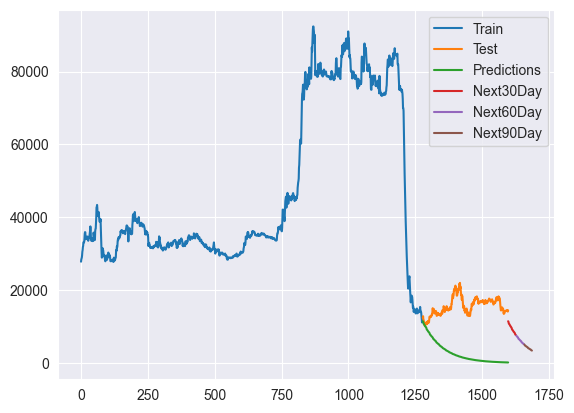

In [20]:
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(test_data.index, y_pred)
plt.plot(last_data1,y_next_90_days[0:30])
plt.plot(last_data2,y_next_90_days[31:60])
plt.plot(last_data3,y_next_90_days[61:90])
plt.legend(['Train', 'Test', 'Predictions','Next30Day', 'Next60Day', 'Next90Day'])
plt.show()

In [21]:
alphas = betas = gammas = np.arange(0.10, 1, 0.10)
abg = list(itertools.product(alphas, betas, gammas))
best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(x_train, x_test, abg=abg, trend='mul', seasonal='add', seasonal_periods=12, step=320)
final_model = ExponentialSmoothing(y_train, trend='mul', seasonal='add', seasonal_periods=12).fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)
y_pred = final_model.forecast(320)


In [22]:
# 6. Quá trình tạo index predict 90 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+90, step=1)
last_data1 = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
last_data2 = pd.RangeIndex(start=last_index+31, stop=last_index+60, step=1)
last_data3 = pd.RangeIndex(start=last_index+61, stop=last_index+90, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_90_days = np.array(range(last_index+1, last_index+91)).reshape(-1, 1)

y_next_90_days = final_model.forecast(len(x_next_90_days))
y_next_90_days



array([11481.37062565, 11478.68421316, 11380.75641283, 11601.52267551,
       11691.82772594, 12068.76563788, 11739.43453048, 11183.17680242,
       10963.36204257, 10541.2636281 , 10259.39564972, 10213.74494496,
       10061.34677265, 10073.60954435,  9990.47355192, 10225.87590295,
       10330.66296151, 10721.93042343, 10406.77801286,  9864.54971656,
        9658.61669479,  9250.25387954,  8981.97689999,  8949.77411594,
        8810.68229246,  8836.11133151,  8766.00299962,  9014.29586357,
        9131.83773124,  9535.72572706,  9233.06098877,  8703.1889018 ,
        8509.48201039,  8113.21661591,  7856.90970253,  7836.55097078,
        7709.1785123 ,  7746.2035417 ,  7687.56912433,  7947.21511211,
        8075.99058453,  8490.99392426,  8199.327514  ,  7680.33797108,
        7497.39905862,  7111.78828408,  6866.02382502,  6856.09656275,
        6739.04575733,  6786.28377943,  6737.75483832,  7007.39991779,
        7146.06921729,  7570.86222764,  7288.88242806,  6779.47752082,
      

In [23]:
test_mae = mean_absolute_error(test_data, y_pred)
test_mape = mean_absolute_percentage_error(test_data, y_pred)
test_rmse = sqrt(mean_squared_error(test_data, y_pred))

print('MAE:', test_mae)
print('RMSE:', test_rmse)
print('MAPE:', test_mape)


MAE: 12236.031483532117
RMSE: 13173.659403802387
MAPE: 0.7567913444910077


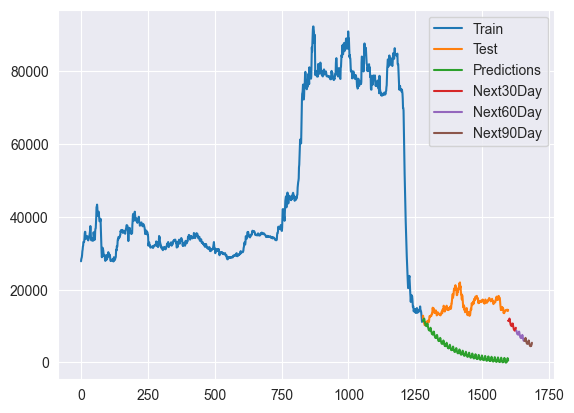

In [24]:
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(test_data.index, y_pred)
plt.plot(last_data1,y_next_90_days[0:30])
plt.plot(last_data2,y_next_90_days[31:60])
plt.plot(last_data3,y_next_90_days[61:90])
plt.legend(['Train', 'Test', 'Predictions','Next30Day', 'Next60Day', 'Next90Day'])
plt.show()

In [25]:
alphas = betas = gammas = np.arange(0.10, 1, 0.10)
abg = list(itertools.product(alphas, betas, gammas))
best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(x_train, x_test, abg=abg, trend='add', seasonal='mul', seasonal_periods=12, step=320)
final_model = ExponentialSmoothing(y_train, trend='add', seasonal='mul', seasonal_periods=12).fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)
y_pred = final_model.forecast(320)


In [26]:
# 6. Quá trình tạo index predict 90 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+90, step=1)
last_data1 = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
last_data2 = pd.RangeIndex(start=last_index+31, stop=last_index+60, step=1)
last_data3 = pd.RangeIndex(start=last_index+61, stop=last_index+90, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_90_days = np.array(range(last_index+1, last_index+91)).reshape(-1, 1)

y_next_90_days = final_model.forecast(len(x_next_90_days))
y_next_90_days



array([11407.91756058, 11243.46108252, 10848.89018891, 10528.57721587,
       10385.46411314, 10237.66906189, 10018.4034582 ,  9806.02396431,
        9568.58835491,  9341.57160601,  9222.16550663,  8993.73502018,
        8780.58517003,  8603.33414951,  8250.57061841,  7955.62078147,
        7794.72130076,  7629.57742558,  7410.81276575,  7197.1243741 ,
        6965.13785592,  6740.92247051,  6593.78098173,  6368.09428681,
        6153.25277947,  5963.2072165 ,  5652.25104791,  5382.66434707,
        5203.97848839,  5021.48578928,  4803.22207331,  4588.22478389,
        4361.68735692,  4140.27333501,  3965.39645683,  3742.45355345,
        3525.92038891,  3323.08028349,  3053.9314774 ,  2809.70791266,
        2613.23567601,  2413.39415297,  2195.63138086,  1979.32519368,
        1758.23685793,  1539.6241995 ,  1337.01193193,  1116.81282008,
         898.58799836,   682.95335048,   455.6119069 ,   236.75147826,
          22.49286363,  -194.69748334,  -411.95931159,  -629.57439653,
      

In [27]:
test_mae = mean_absolute_error(test_data, y_pred)
test_mape = mean_absolute_percentage_error(test_data, y_pred)
test_rmse = sqrt(mean_squared_error(test_data, y_pred))

print('MAE:', test_mae)
print('RMSE:', test_rmse)
print('MAPE:', test_mape)


MAE: 38953.82849698055
RMSE: 44370.68877477194
MAPE: 2.4245993774202326


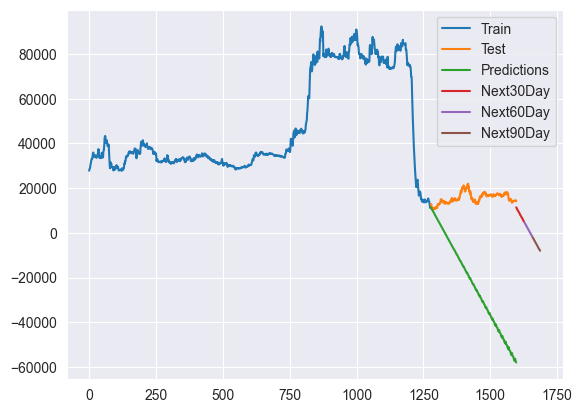

In [28]:
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(test_data.index, y_pred)
plt.plot(last_data1,y_next_90_days[0:30])
plt.plot(last_data2,y_next_90_days[31:60])
plt.plot(last_data3,y_next_90_days[61:90])
plt.legend(['Train', 'Test', 'Predictions','Next30Day', 'Next60Day', 'Next90Day'])
plt.show()

###### Observation:
-  Triple Exponential Smoothing with both multiplicative trend and seasonality  acchieve the best MAE, RMSE, MAPE score  -> choose the model